# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

# article of nice plots: https://towardsdatascience.com/how-to-create-and-use-custom-matplotlib-style-sheet-9393f498063

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'viridis'

res = 200

# rcParams parameters https://matplotlib.org/stable/users/dflt_style_changes.html

# colorbar function

In [21]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

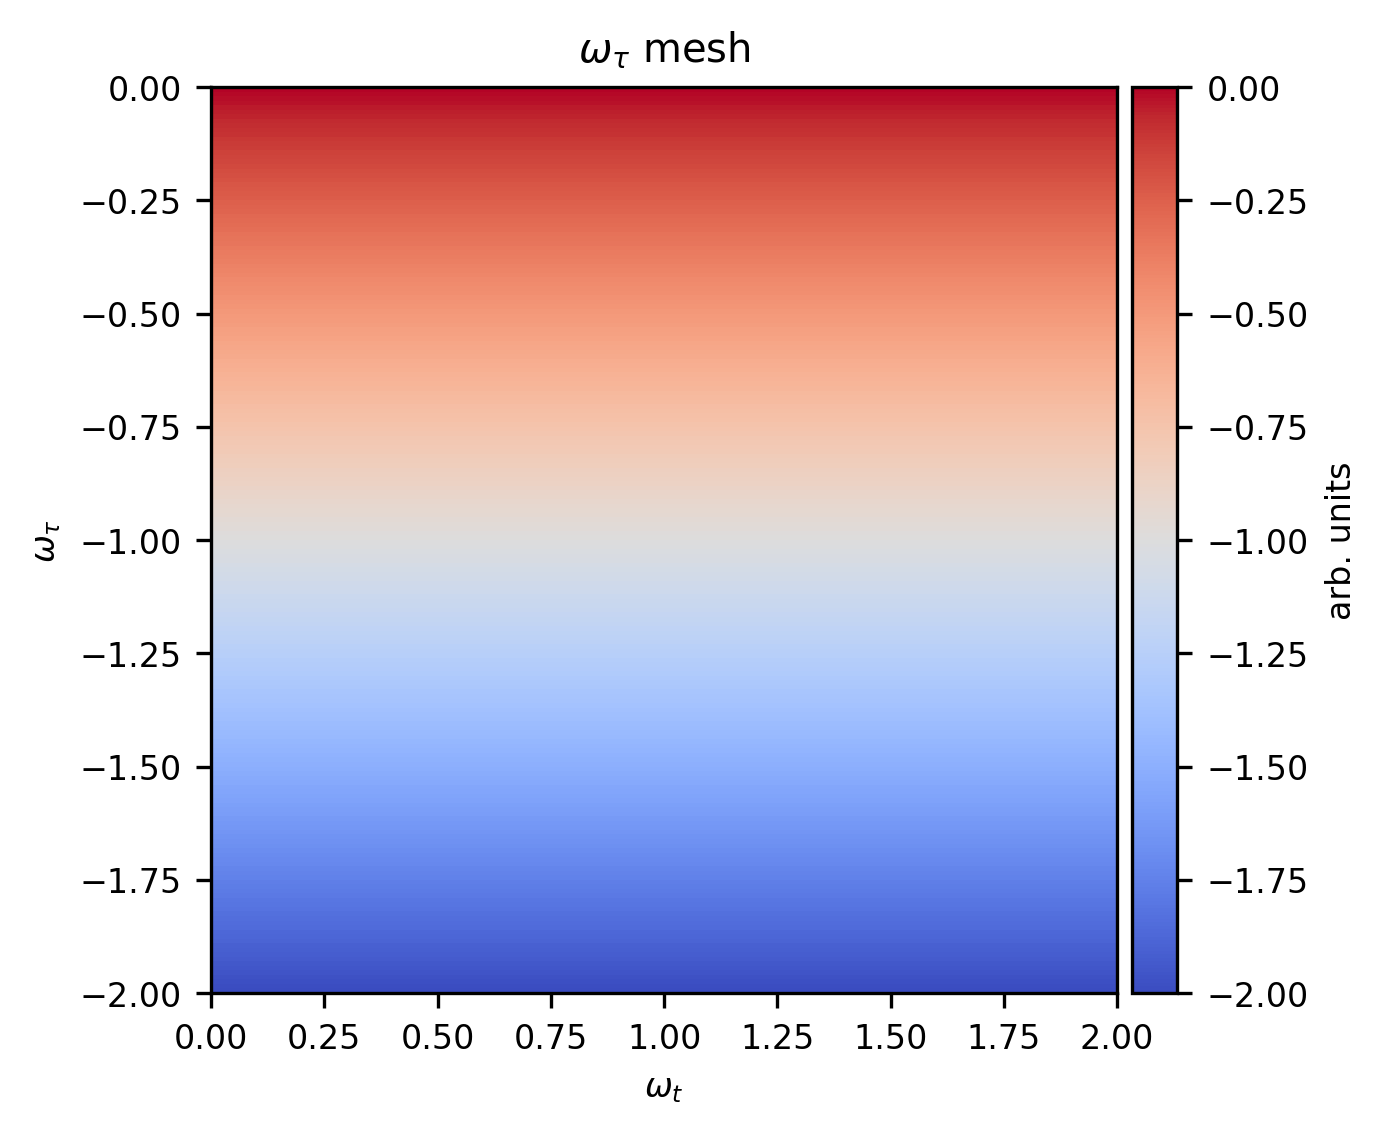

In [22]:
omega_t = np.linspace(0., 2., res)
omega_tau = np.linspace(-2., 0., res)
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')
plt.figure()
im = plt.imshow(omega_tau_mesh, 
                origin='lower', 
                extent=(min(omega_t), 
                        max(omega_t), 
                        min(omega_tau), 
                        max(omega_tau)))
plt.xlabel(r'$\omega_t$')
plt.ylabel(r'$\omega_\tau$')
plt.title(r'$\omega_\tau$ mesh')
colorbar(im)
plt.show()

# multiple plot function

In [23]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'$\omega_t \quad$',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'$\omega_\tau \quad$',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(omega_t), max(omega_t), min(omega_tau), max(omega_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i].T,
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [24]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [25]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phi(x):

    return cmath.phase(x)

# parameters

In [26]:
Delta_ZPL_0 = 1.
lambda_SO_gs = 0.5
lambda_SO_es = 0.1

t_para = 1.
t_perp = 0.1
d_gs = 1.
d_es = 1.
f_gs = -1.
f_es = -1.

sigma = 0.2 * Delta_ZPL_0
gamma_10 = 0.05 * sigma

\begin{equation}\label{eq:1}
    \Delta_{ZPL}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}) = \Delta_{ZPL,0} + (t_{\parallel,es} - t_{\parallel,gs})\epsilon_{zz} + (t_{\perp,es} - t_{\perp,gs})(\epsilon_{xx} + \epsilon_{yy})
\end{equation}


In [27]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

\begin{equation}\label{eq:2}
    \Delta_{gs}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,gs}^2 + 4[d_{gs}(\epsilon_{xx} - \epsilon_{yy}) + f_{gs} \epsilon_{yz}]^2 + 4[-2d_{gs} \epsilon_{xy} + f_{gs} \epsilon_{zx}]^2}
\end{equation}

In [28]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

\begin{equation}\label{eq:3}
    \Delta_{es}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,es}^2 + 4[d_{es}(\epsilon_{xx} - \epsilon_{yy}) + f_{es} \epsilon_{yz}]^2 + 4[-2d_{es} \epsilon_{xy} + f_{es} \epsilon_{zx}]^2}
\end{equation}

In [29]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

\begin{equation}\label{eq:4}
    \rho (\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = - \left( \frac{1}{\omega_t-[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} - i \gamma_{10}]} \right ) \left (\frac{1}{\omega_{\tau}+[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} + i \gamma_{10}]} \right)
\end{equation}


In [38]:
@numba.jit
def rho(omega_t, 
        omega_tau, 
        eps_xx = 0., 
        eps_yy = 0., 
        eps_zz = 0., 
        eps_yz = 0., 
        eps_xy = 0., 
        eps_zx = 0.):
    
    Del_ZPL = Delta_ZPL(eps_xx, 
                        eps_yy, 
                        eps_zz)
    
    Del_gs = Delta_gs(eps_xx, 
                      eps_yy, 
                      eps_yz, 
                      eps_xy, 
                      eps_zx)
    
    Del_es = Delta_es(eps_xx, 
                      eps_yy, 
                      eps_yz, 
                      eps_xy, 
                      eps_zx)
    
    amp = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
    
    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.], 
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.],
                     [ 1., -1.,  1., -1.], 
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.], 
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.],
                     [-1.,  1., -1.,  1.], 
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.], 
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])
        
#     if not len(np.shape(omega_t)):
                
#         t_Lorentz   = 1.j*amp*gamma_10 / (omega_t   - (Del_ZPL + sign[:,0]*Del_gs + sign[:,1]*Del_es - 1.j*gamma_10))
#         tau_Lorentz = 1.j*amp*gamma_10 / (omega_tau + (Del_ZPL + sign[:,2]*Del_gs + sign[:,3]*Del_es + 1.j*gamma_10))
        
#         RHO = np.sum(t_Lorentz*tau_Lorentz)
        
        
#     else:
            
    RHO = 1.j*np.zeros(np.shape(omega_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz   = 1.j*amp[i]*gamma_10 / (omega_t   - (Del_ZPL + sign[i,0]*Del_gs + sign[i,1]*Del_es - 1.j*gamma_10))
        tau_Lorentz = 1.j*amp[i]*gamma_10 / (omega_tau + (Del_ZPL + sign[i,2]*Del_gs + sign[i,3]*Del_es + 1.j*gamma_10))

        RHO += t_Lorentz * tau_Lorentz
        
    return RHO

# Testing/sanity check, the mesh indexing convention can be weird

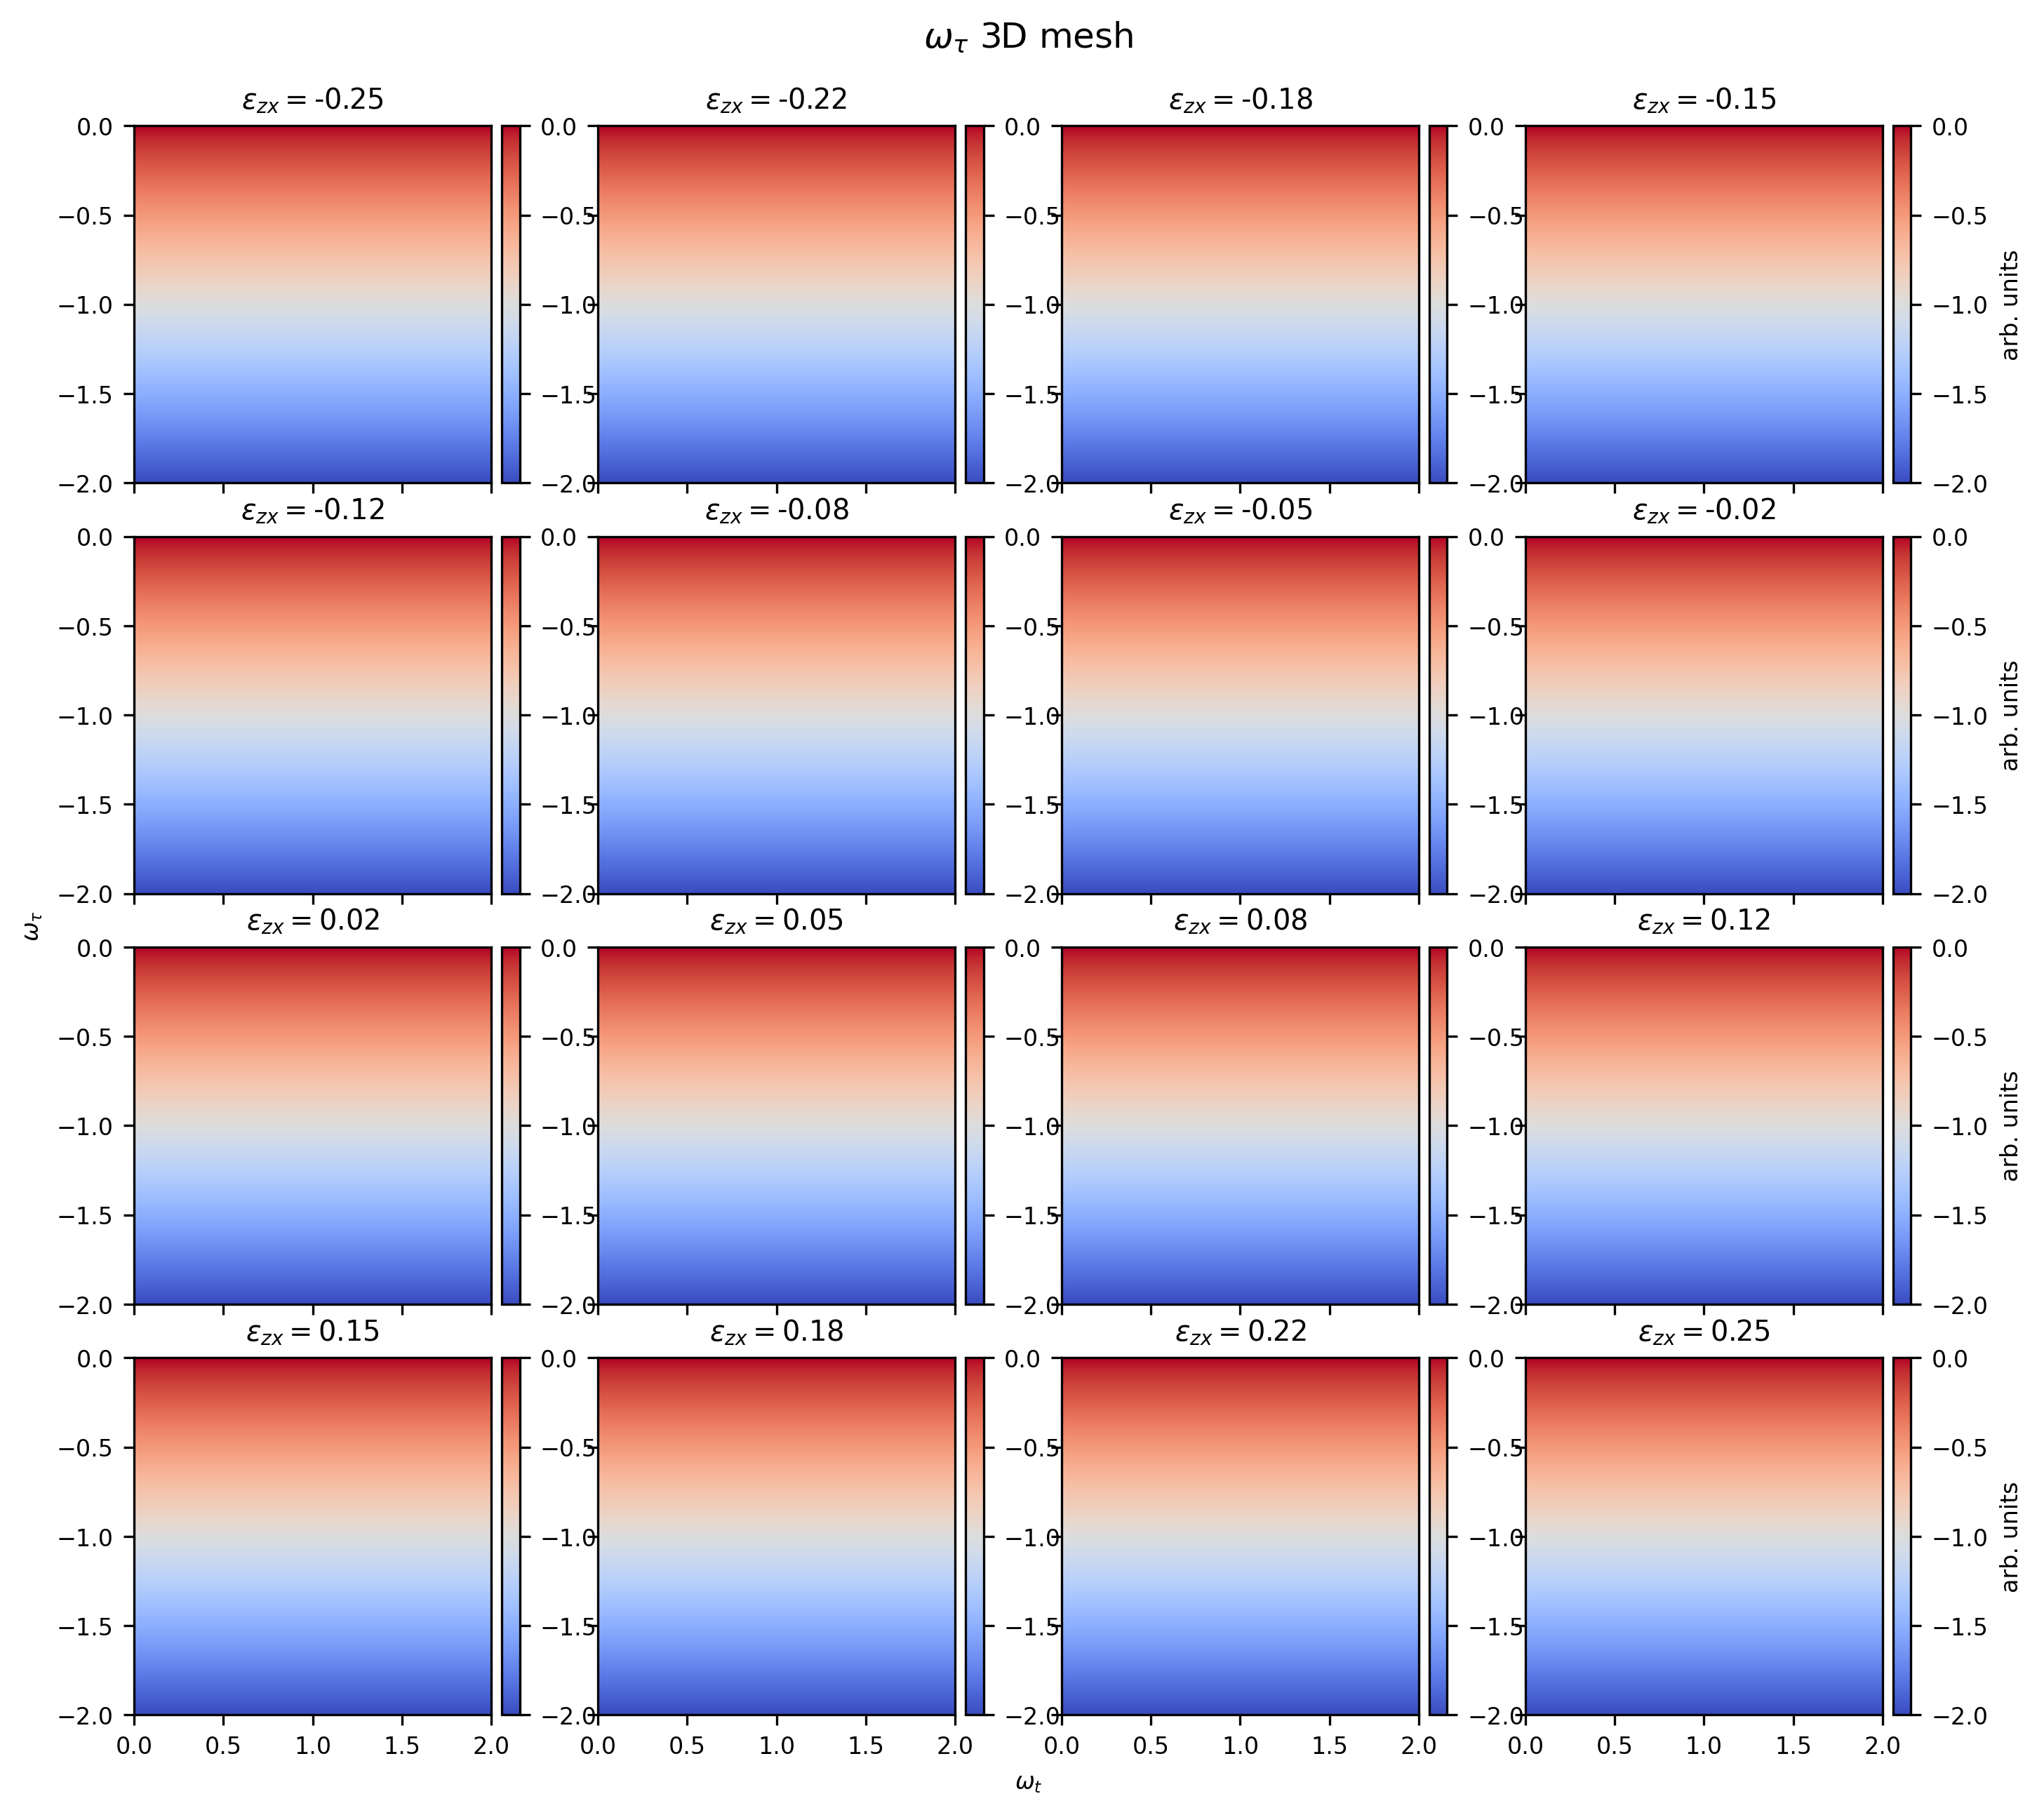

In [31]:
eps_zx_vals = np.linspace(-0.25, 0.25, 16)
eps_zx_3Dmesh, omega_t_3Dmesh, omega_tau_3Dmesh = np.meshgrid(eps_zx_vals,
                                                              omega_t,
                                                              omega_tau,
                                                              indexing='ij')

_ = slices_plots(omega_tau_3Dmesh,
                 shared_title=r'$\omega_\tau$ 3D mesh',
                 titles=[r'$\epsilon_{zx} =$'
                         f'{i:.2f}' for i in eps_zx_vals])

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/2939395974.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fb16e03be50>)) with parameters (float64, float64, float64, float64, array(float64, 3d, C))

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fb16e03be50>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/2939395974.py (15)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/2939395974.py", line 15:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/2939395974.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core

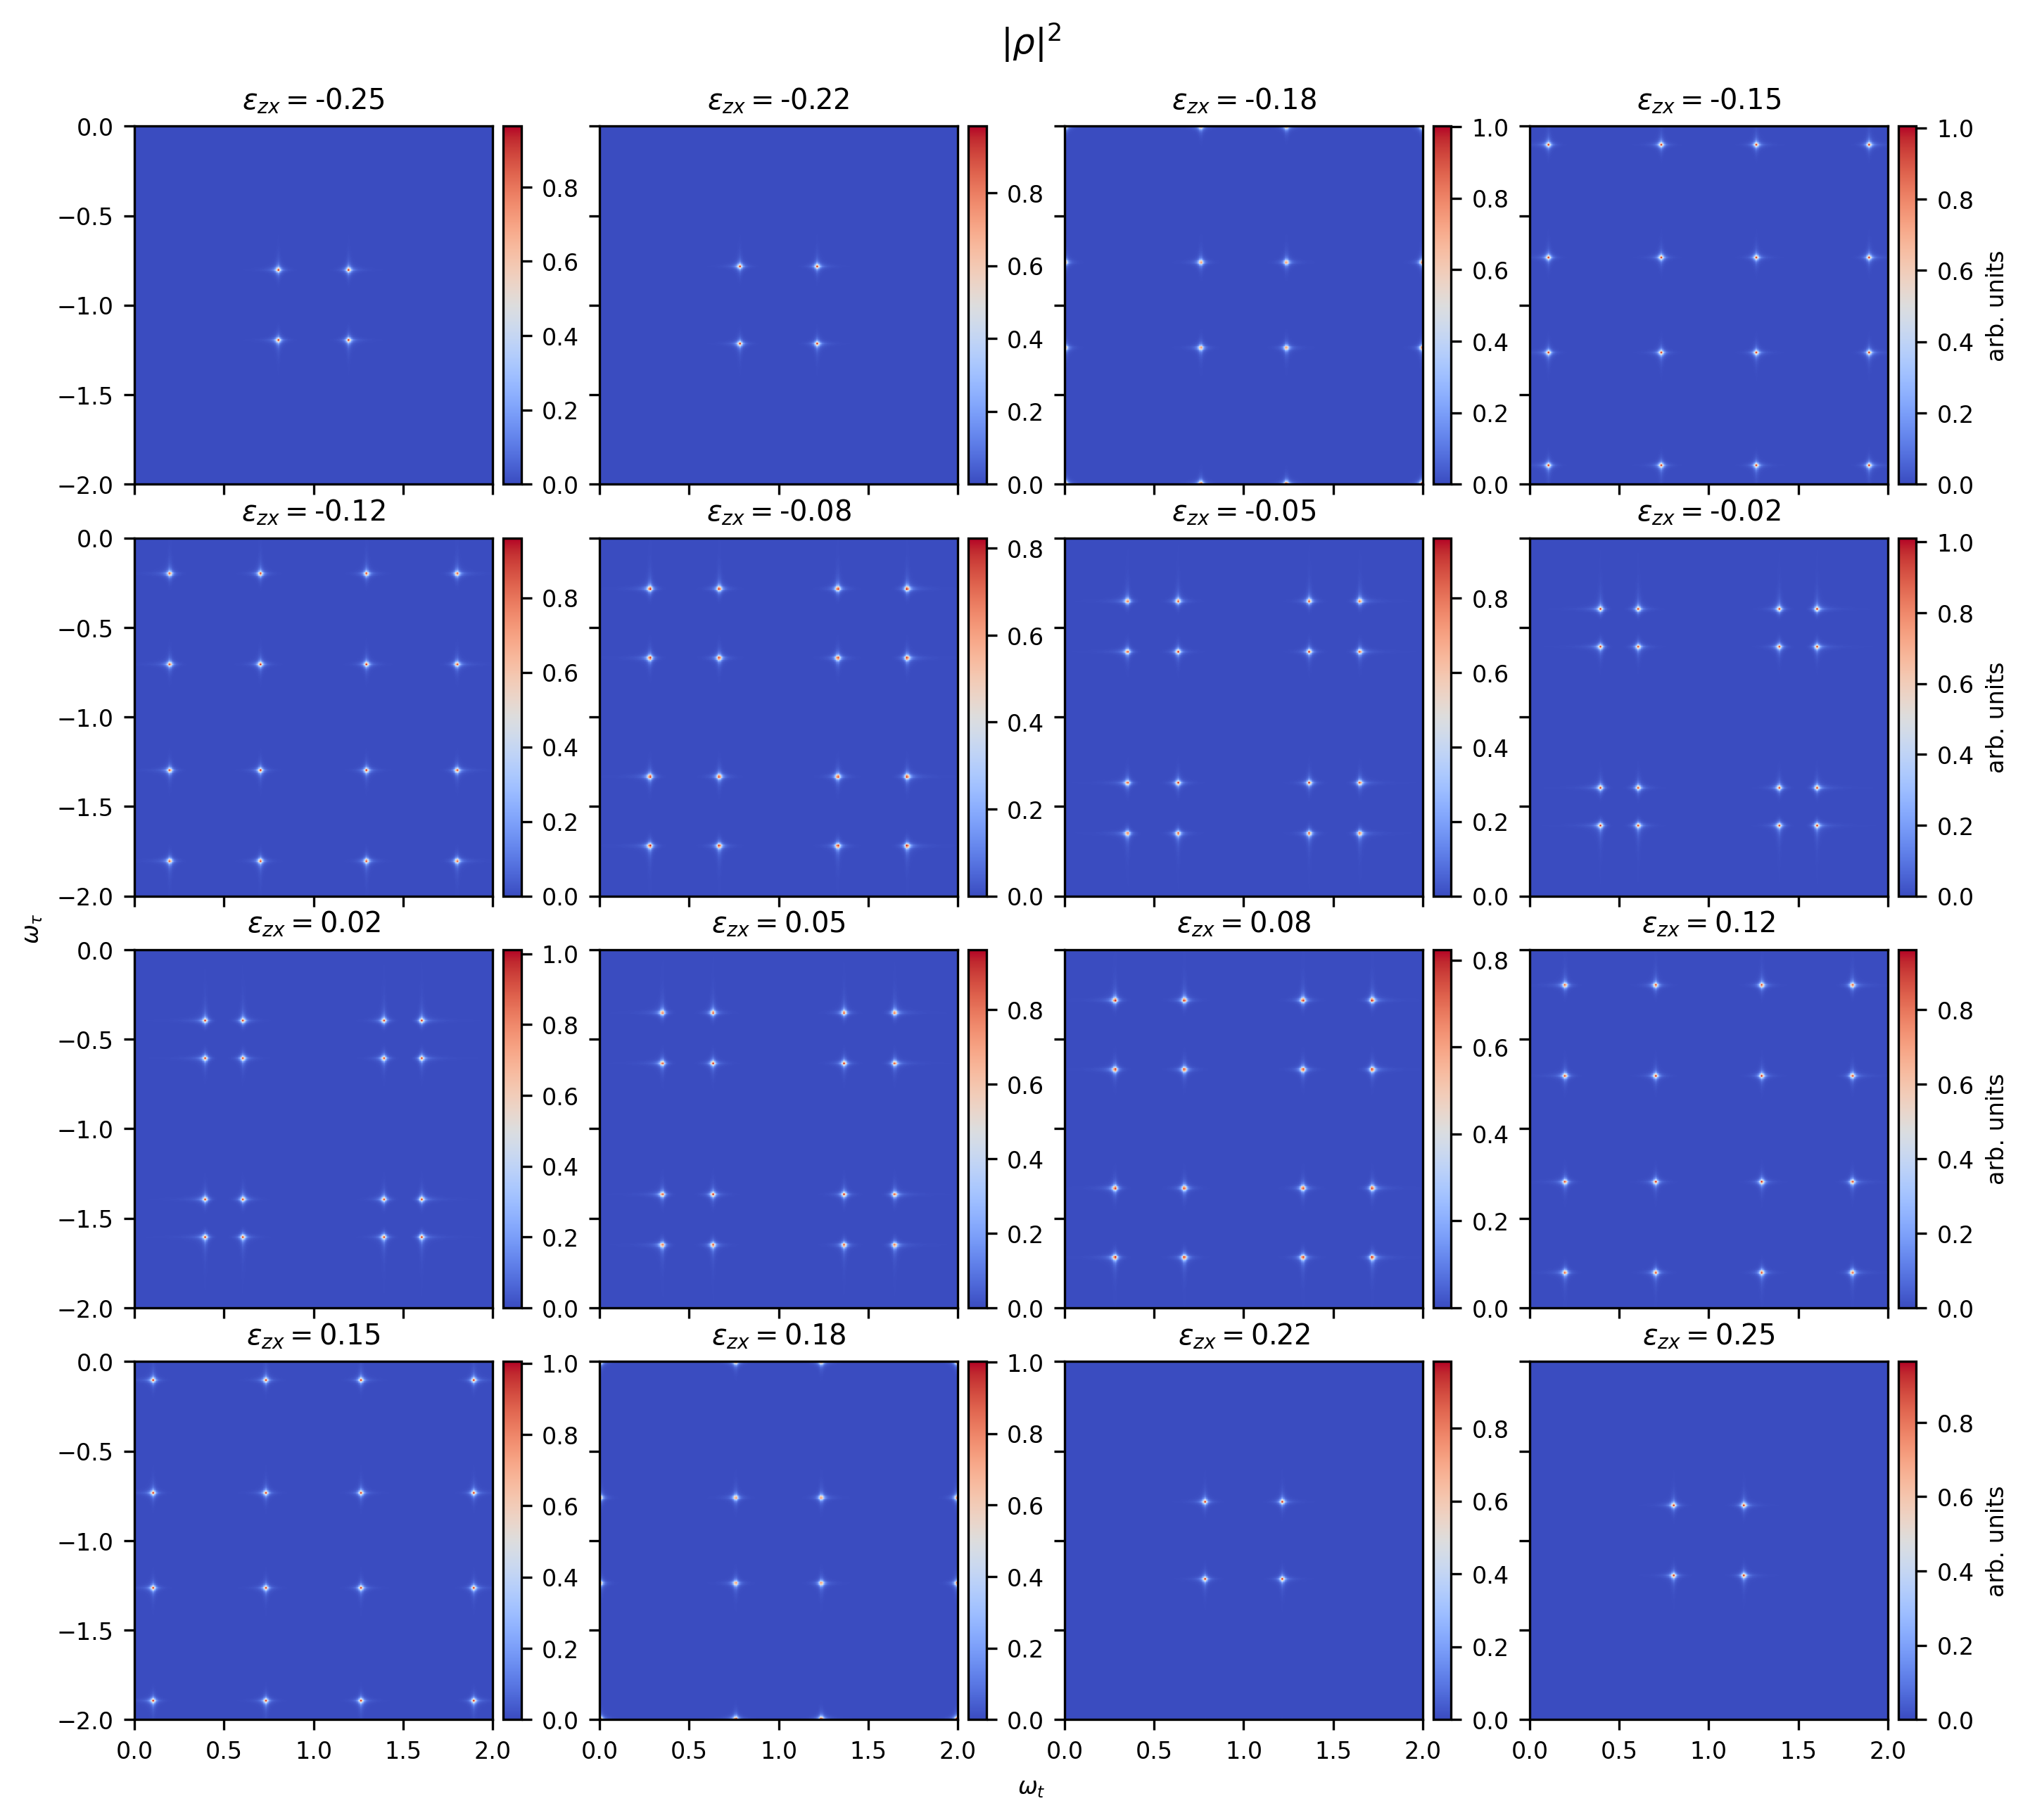

In [32]:
RHOs = rho(omega_t_3Dmesh, 
           omega_tau_3Dmesh, 
           eps_zx=eps_zx_3Dmesh)

_ = slices_plots(abs2(RHOs),
                 shared_title=r'$|\rho|^2$', 
                 titles = [r'$\epsilon_{zx} =$' 
                           f'{i:.2f}' for i in eps_zx_vals])

# Istropic Strain

\begin{equation}\label{eq:5}
    I_{iso}\left(\omega_t, \omega_\tau \right) \propto \int^{\infty}_{-\infty} d \epsilon_{zz} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}\right)
\end{equation}

# computing integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

In [33]:
@numba.jit
def Gaus(eps_ij):
    
    return 1. / sigma / np.sqrt(2. * np.pi) * np.exp(-eps_ij**2. / 2. / sigma**2.)

In [59]:
@numba.jit
def infint(func):
    
    return spint.quad_vec(func, -np.inf, np.inf)

In [60]:
func = lambda eps_zz: Gaus(eps_zz) * rho(omega_t_mesh, omega_tau_mesh, eps_zz=eps_zz)
I_iso, int_err_iso = infint(func)
I_iso /= np.sqrt(np.max(abs2(I_iso)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py (4)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDep

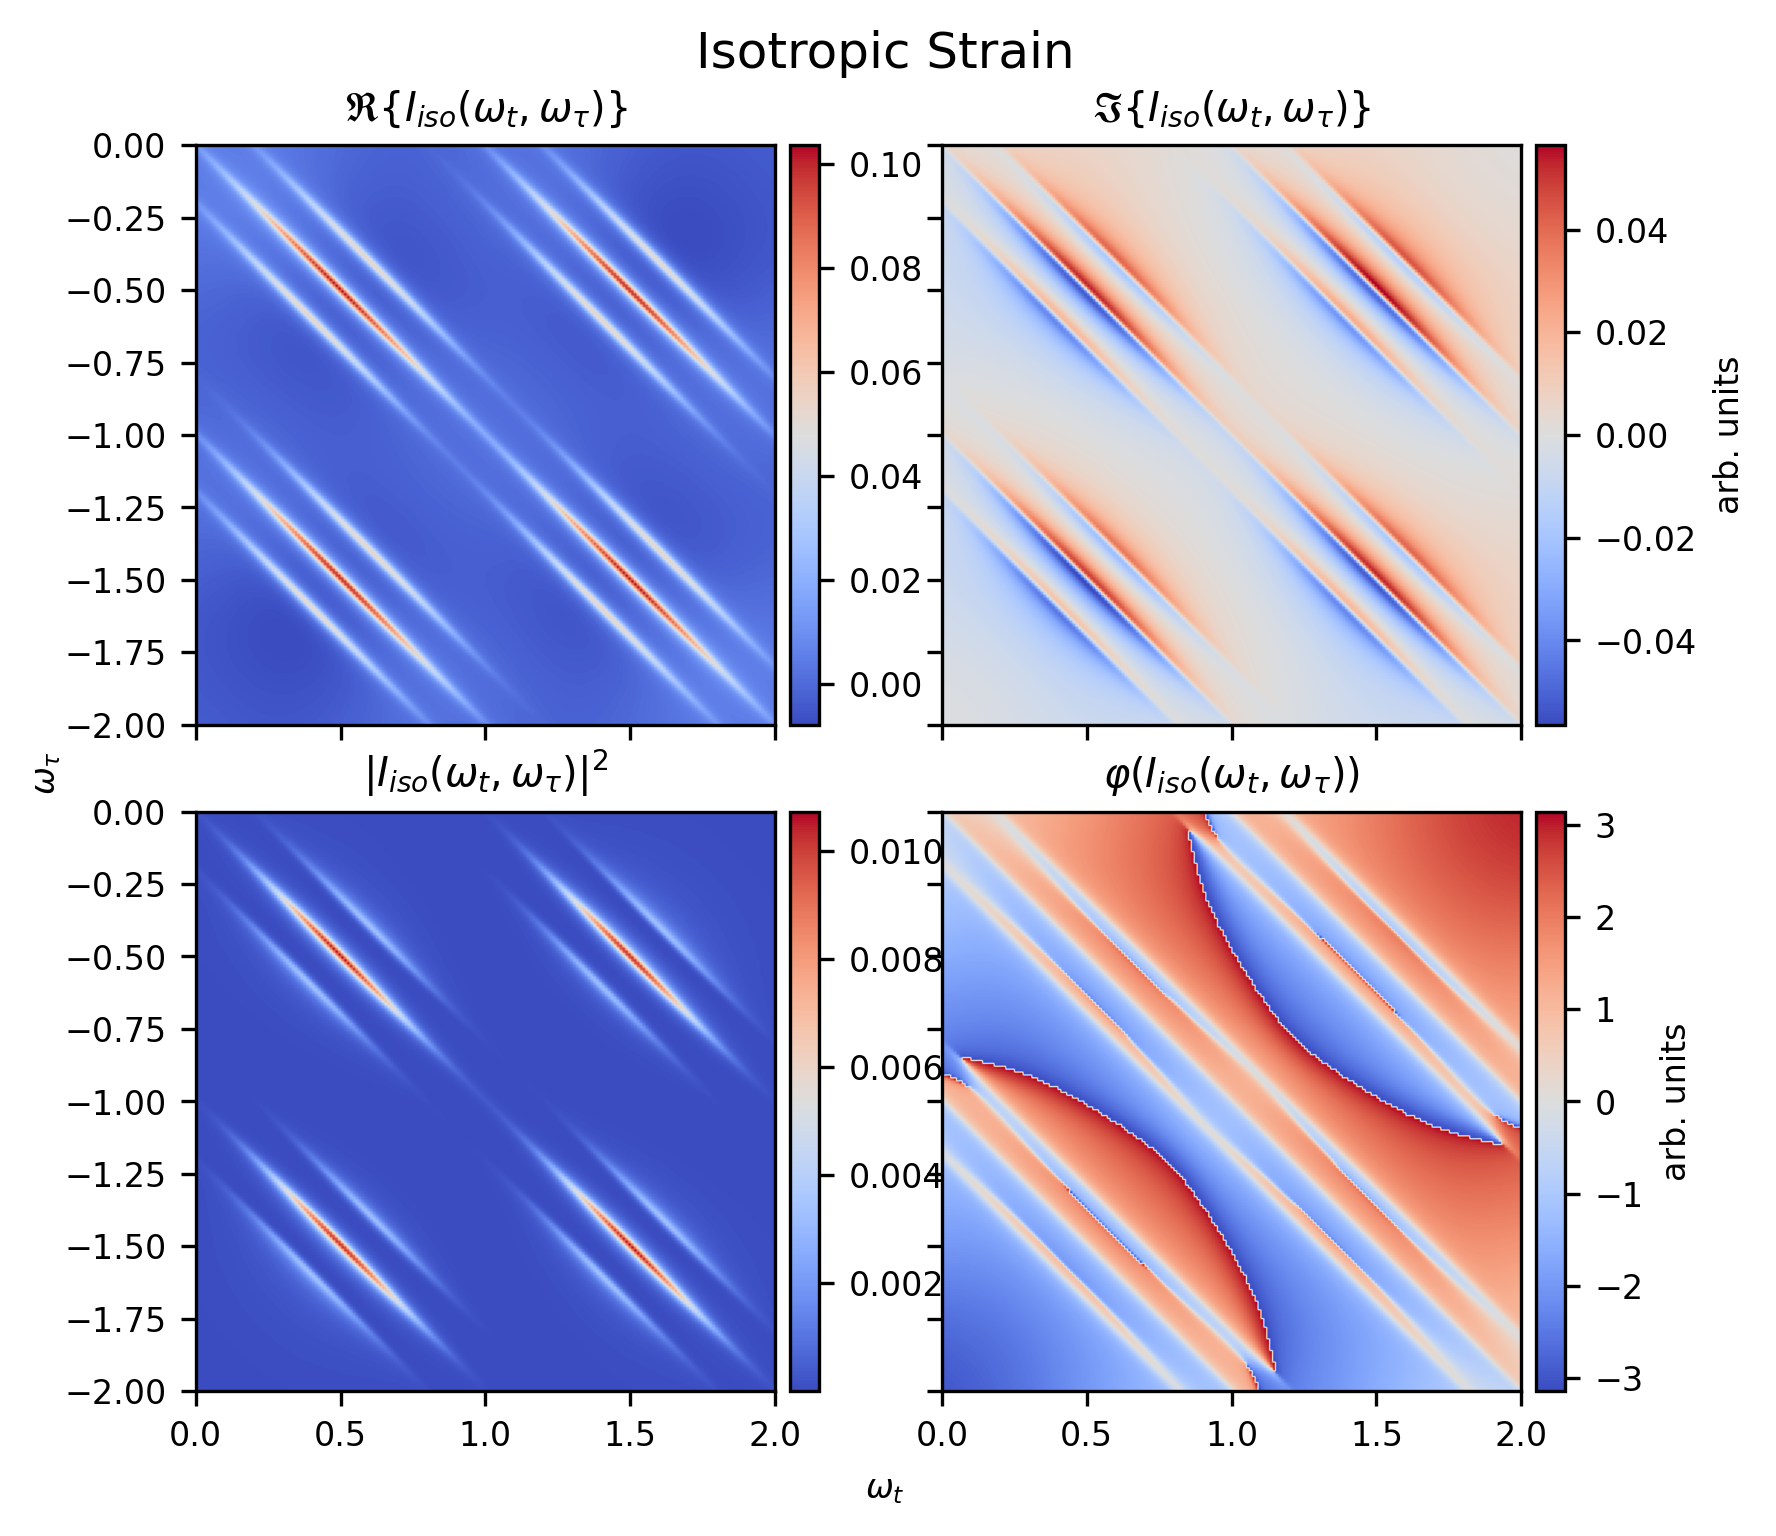

In [61]:
I_iso_ReImAmPh = np.array([I_iso.real, I_iso.imag, abs2(I_iso), phi(I_iso)])
figPL = slices_plots(I_iso_ReImAmPh, 
                      shared_title='Isotropic Strain', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{iso} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{iso} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{iso} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{iso} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

# Randomly varying all 6 strain indices

\begin{align}\label{eq:aa}
    I_{rand6}\left(\omega_t, \omega_\tau \right) \propto
    & \int \dots \int^{\infty}_{-\infty} d \epsilon_{xx} d \epsilon_{yy} d \epsilon_{zz} d \epsilon_{yz} d \epsilon_{xy} d \epsilon_{zx} \\ 
    & \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right] \\ 
    & \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right)
\end{align}

# Monte Carlo Integration

\begin{align}\label{eq:8}
\int_{\bar{x_a}}^{\bar{x_b}} f(\bar{x}) \, d\bar{x} 
& = \left \langle \frac{f(\bar{x})}{p(\bar{x})} \right \rangle_p \int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x} \\
& \approx \frac{1}{N} \sum_i^N \frac{f(\bar{x}_i)}{p(\bar{x}_i)} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, d\bar{x}
\end{align}

\begin{equation}\label{eq:}
\bar{x} \in \{ x_1, x_2, x_3, \dots\}
\end{equation}


## random numbers drawn from $p(x)$

\begin{equation}\label{eq:9}
f \left(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right] \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}\right)
\end{equation}


\begin{equation}\label{eq:10}
p \left (\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right]
\end{equation}


\begin{equation}\label{eq:12}
\int \dots \int^{\infty}_{-\infty} d \epsilon_{xx} d \epsilon_{yy} d \epsilon_{zz} d \epsilon_{yz} d \epsilon_{xy} d \epsilon_{zx} \, p \left (\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = 1
\end{equation}


\begin{align}\label{eq:14}
 I_{rand6}(\omega_t, \omega_\tau)
& \propto \left \langle \frac{f(\bar{\epsilon})}{p \left(\bar{\epsilon} \right)} \right \rangle_p \int_{\bar{\epsilon_a}}^{\bar{\epsilon_b}}p(\bar{\epsilon}) \, d\bar{\epsilon} \\
& \tilde{\propto} \frac{1}{N} \sum_i^N \frac{f(\bar{\epsilon}_i)}{p(\bar{\epsilon}_i)} \\
& \tilde{\propto} \frac{1}{N} \sum_i^N \rho \left (\omega_t, \omega_{\tau}, \epsilon_{xx_i}, \epsilon_{yy_i}, \epsilon_{zz_i}, \epsilon_{yz_i}, \epsilon_{xy_i}, \epsilon_{zx_i} \right) \\
\end{align}

In [125]:
@numba.jit
def MCint(
    omega_t=omega_t, 
    omega_tau=omega_tau,
    N=int(1e3)  # MC Steps
):

    randn_eps = sigma * np.random.randn(6, N)  # normal distribution

    I_random6 = 1.j*np.zeros((res, res))

    for i, om_t in enumerate(omega_t):
        for j, om_tau in enumerate(omega_tau):
            I_random6[i, j] = np.mean(
                rho(om_t, om_tau, randn_eps[0], randn_eps[1], randn_eps[2],
                    randn_eps[3], randn_eps[4], randn_eps[5]))

    return I_random6 / np.sqrt(np.max(abs2(I_random6)))

In [126]:
I_random6 = MCint()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/1966207225.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fb18876a5e0>)) with parameters (float64, float64, array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fb18876a5e0>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/1966207225.py (15)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/1966207225.py", line 15:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/1966207225.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Funct

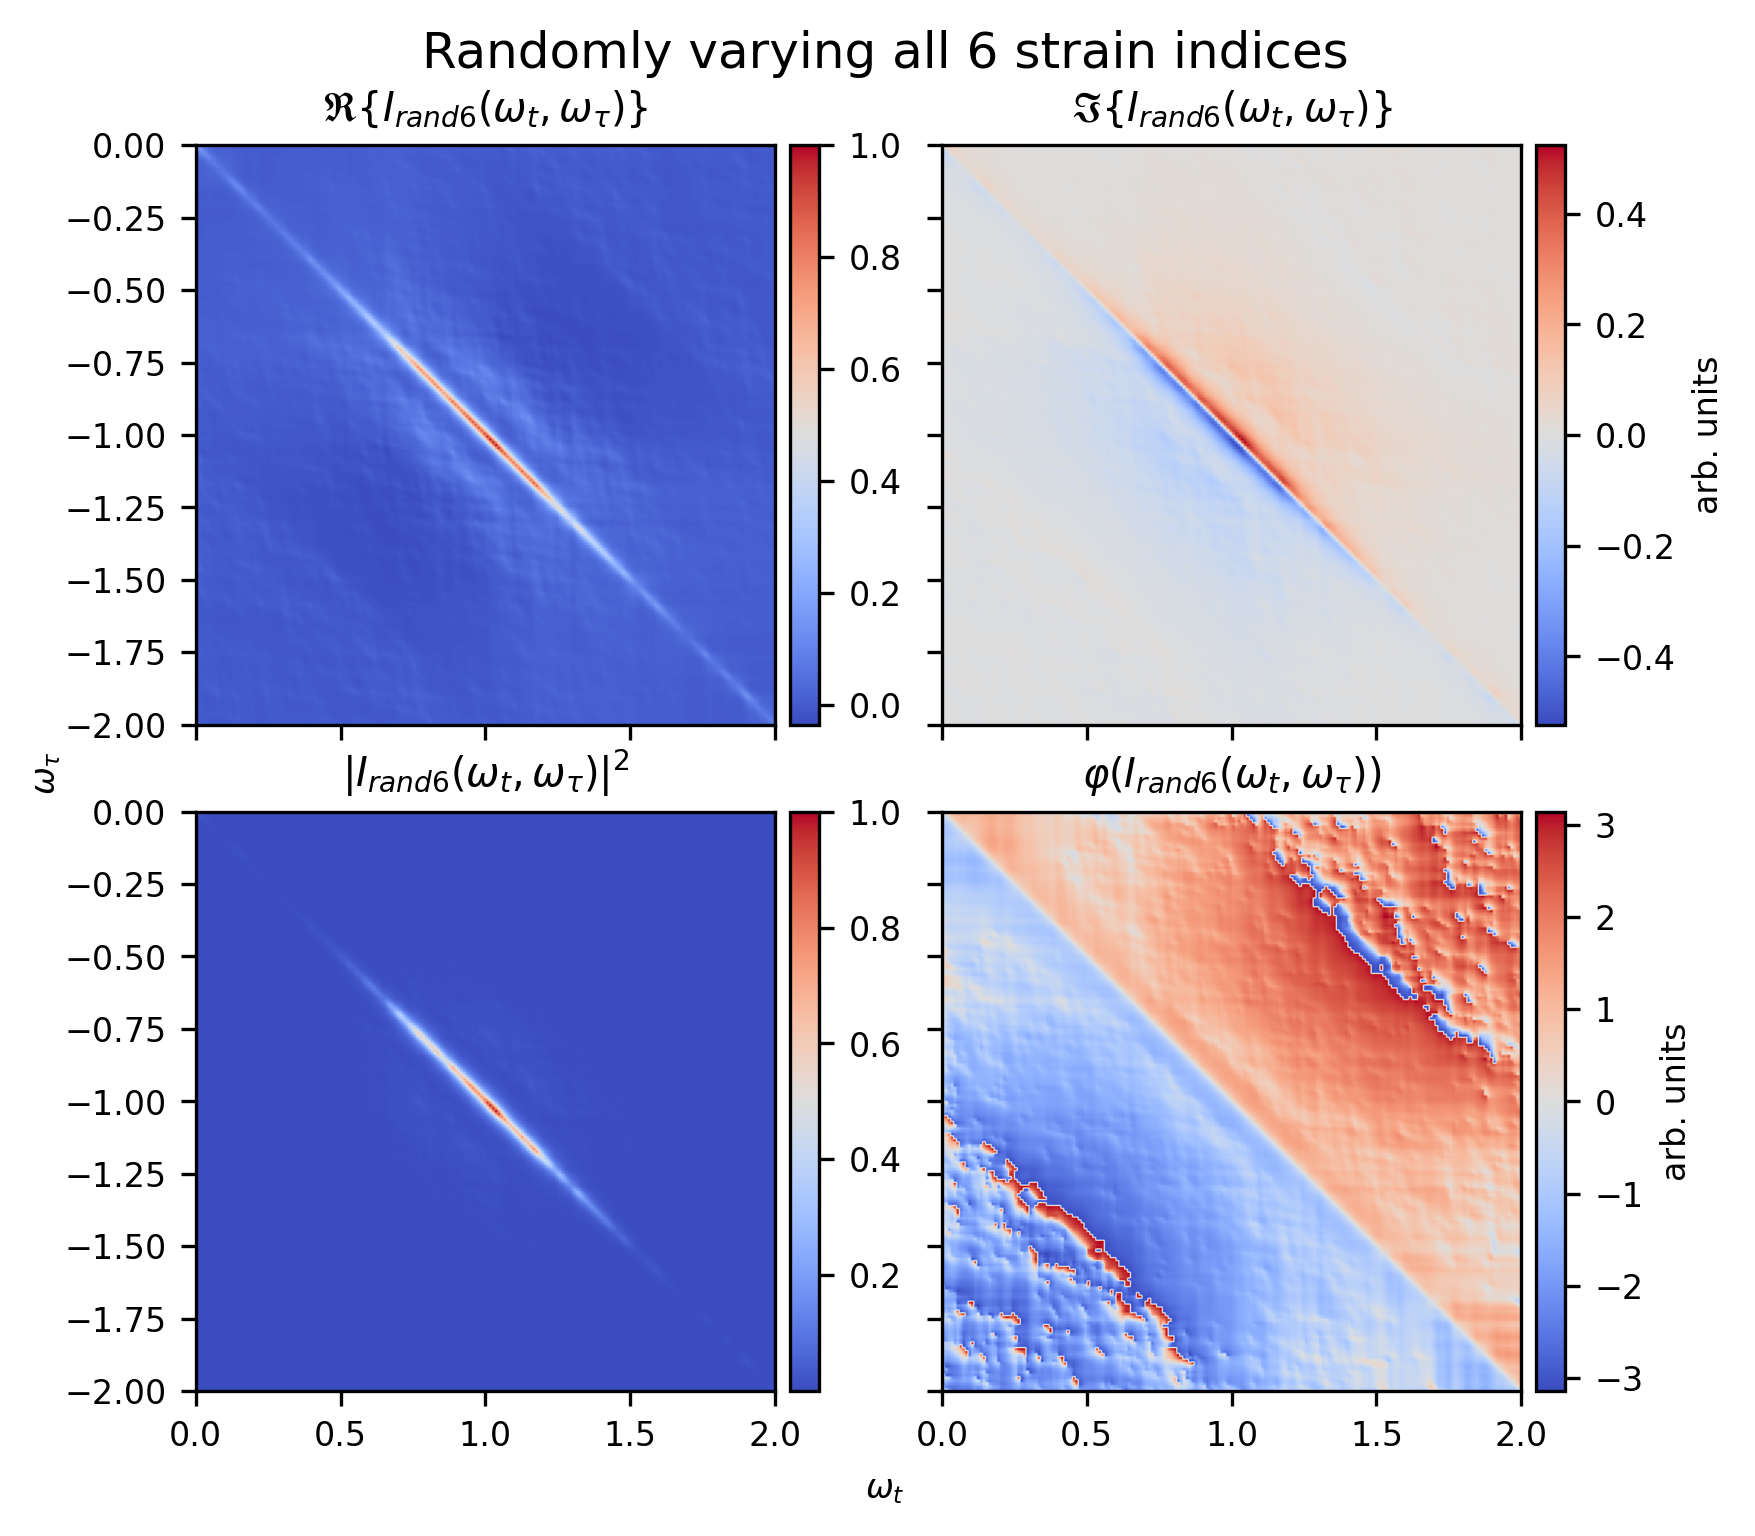

In [127]:
I_random6_ReImAmPh = np.array([I_random6.real, I_random6.imag, abs2(I_random6), phi(I_random6)])
fig_random6 = slices_plots(I_random6_ReImAmPh, 
                      shared_title='Randomly varying all 6 strain indices', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{rand6} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{rand6} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{rand6} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{rand6} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

In [41]:
fig_random6.savefig("/Users/tommychin/Documents/research/Smallwood_research/random6.pdf", 
                 format='pdf', 
                 bbox_inches='tight')

https://stackoverflow.com/questions/14071704/integrating-a-multidimensional-integral-in-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html

https://www.google.com/search?q=monte+carlo+multidimensional+integration&oq=monte+carlo+multi&aqs=chrome.1.69i57j0i512l3j46i175i199i512j0i512j0i22i30l4.8511j0j7&sourceid=chrome&ie=UTF-8

# $\epsilon_{zz}$ in random directions

\[
R_z(\theta) \, R_x(\phi) \,
\begin{pmatrix}
p \, \epsilon_{zz_0} & 0 & 0\\
0 & p \, \epsilon_{zz_0} & 0\\
0 & 0 & \epsilon_{zz_0}\\
\end{pmatrix}
\, R_x^T(\phi) \, R_z^T(\theta)
\]

\[
\begin{pmatrix}
\cos{\theta} & - \sin{\theta} & 0\\
\sin{\theta} & \cos{\theta} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\phi} & - \sin{\phi}\\
0 & \sin{\phi} & \cos{\phi}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{zz_0} & 0 & 0\\
0 & p \, \epsilon_{zz_0} & 0\\
0 & 0 & \epsilon_{zz_0}\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\phi} & \sin{\phi}\\
0 & - \sin{\phi} & \cos{\phi}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\theta} & \sin{\theta} & 0\\
- \sin{\theta} & \cos{\theta} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
\left [p \, \cos^2{\theta} + \sin^2{\theta}\left (p \, \cos^2{\phi} + \sin^2{\phi} \right ) \right ]\epsilon_{zz_0} & \left( p - 1 \right) \frac{\sin{2 \theta}}{2} \, \sin^2{\phi} \, \epsilon_{zz_0} & \left( 1 - p \right) \sin{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0}\\
\left( p - 1 \right) \frac{\sin{2 \theta}}{2} \, \sin^2{\phi} \, \epsilon_{zz_0} & \left [p \, \sin^2{\theta} + \cos^2{\theta}\left (p \, \cos^2{\phi} + \sin^2{\phi} \right ) \right ]\epsilon_{zz_0} & \left( p - 1 \right) \cos{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0}\\
\left( 1 - p \right) \sin{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0} & \left( p - 1 \right) \cos{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0} & \left (\cos^2{\phi} + p \, \sin^2{\phi} \right )\epsilon_{zz_0}\\
\end{pmatrix}
\]

\begin{equation}\label{eq:21}
\epsilon'_{xx} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left [p \, \cos^2{\theta} + \sin^2{\theta}\left (p \, \cos^2{\phi} + \sin^2{\phi} \right ) \right ]\epsilon_{zz_0}
\end{equation}

In [42]:
@numba.jit
def eps_xx_p(eps_zz_0, 
             theta, 
             phi):
    
    return ( p*np.cos(theta)**2. + np.sin(theta)**2.*(p*np.cos(phi)**2. + np.sin(phi)**2.) )*eps_zz_0

\begin{equation}\label{eq:22}
\epsilon'_{yy} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left [p \, \sin^2{\theta} + \cos^2{\theta}\left (p \, \cos^2{\phi} + \sin^2{\phi} \right ) \right ]\epsilon_{zz_0}
\end{equation}

In [43]:
@numba.jit
def eps_yy_p(eps_zz_0, 
             theta, 
             phi):
    
    return ( p*np.sin(theta)**2. + np.cos(theta)**2.*(p*np.cos(phi)**2. + np.sin(phi)**2.) )*eps_zz_0

\begin{equation}\label{eq:23}
\epsilon'_{zz} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left (\cos^2{\phi} + p \, \sin^2{\phi} \right )\epsilon_{zz_0}
\end{equation}

In [44]:
@numba.jit
def eps_zz_p(eps_zz_0, 
             theta, 
             phi):
    
    return (np.cos(phi)**2. + p*np.sin(phi)**2.)*eps_zz_0

\begin{equation}\label{eq:24}
\epsilon'_{yz} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( p - 1 \right) \cos{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0}
\end{equation}

In [45]:
@numba.jit
def eps_yz_p(eps_zz_0, 
             theta, 
             phi):
    
    return (p - 1.) * np.cos(theta) * np.sin(2.*phi)/2. * eps_zz_0

\begin{equation}\label{eq:25}
\epsilon'_{xy} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( p - 1 \right) \frac{\sin{2 \theta}}{2} \, \sin^2{\phi} \, \epsilon_{zz_0}
\end{equation}

In [46]:
@numba.jit
def eps_xy_p(eps_zz_0, 
             theta, 
             phi):
    
    return (p - 1.) * np.sin(2.*theta)/2. * np.sin(phi)**2. * eps_zz_0

\begin{equation}\label{eq:26}
\epsilon'_{zx} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( 1 - p \right) \sin{\theta} \, \frac{\sin{2 \phi}}{2} \epsilon_{zz_0}
\end{equation}

In [48]:
@numba.jit
def eps_zx_p(eps_zz_0, 
             theta, 
             phi):
    
    return (1. - p) * np.sin(theta) * np.sin(2.*phi)/2. * eps_zz_0

\begin{align}\label{eq:27}
    I_{randDir}(\omega_t, \omega_\tau) 
    & \propto \int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi \sin{\theta} \, d \theta \int_0^{2\pi} d \phi \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right] \, \rho \left (\omega_t, \omega_{\tau}, \bar{\epsilon}'_{ij} \left (  \epsilon_{zz_0}, \theta, \phi \right ) \right) \\
    & \propto \int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi \sin{\theta} \, d \theta \int_0^{2\pi} d \phi \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right] \, \rho \left (\omega_t, \omega_{\tau},   \epsilon_{zz_0}, \theta, \phi \right )
\end{align}

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html

In [59]:
@numba.jit
def infint(func):
    
    return spint.nquad(func, -np.inf, np.inf)

In [60]:
func = lambda eps_zz: Gaus(eps_zz) * rho(omega_t_mesh, omega_tau_mesh, eps_zz=eps_zz)
I_iso, int_err_iso = infint(func)
I_iso /= np.sqrt(np.max(abs2(I_iso)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py (4)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_3264/3668191973.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDep